# Evaluación: Comparación de Modelos HerdNet vs RF-DETR

### Modelos evaluados:
- **HerdNet** - Baseline CNN con DLA-34
- **RF-DETR Nano** - Detection Transformer (384px)
- **RF-DETR Small** - Detection Transformer (512px)
- **RF-DETR Large** - Detection Transformer (560px)

### Fases de entrenamiento:
- **Stage 1**: Entrenamiento inicial
- **Stage 2**: Fine-tuning con Hard Negative Patches (HNP)

### Especies evaluadas:
- Búfalo (Buffalo)
- Elefante (Elephant)
- Kob
- Topi
- Facóquero (Warthog)
- Cobo de agua (Waterbuck)

## 1. Importación de Librerías y Configuración Inicial

In [35]:
from pathlib import Path
import pandas as pd
import numpy as np
from typing import Dict, List, Optional, Tuple
import json
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle, Circle
from PIL import Image
import warnings

# Configuración de estilo para gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configurar matplotlib para mostrar gráficos inline
%matplotlib inline

# Para métricas de evaluación
try:
    from animaloc.eval.metrics import PointsMetrics
    ANIMALOC_AVAILABLE = True
except ImportError:
    print("⚠️ Advertencia: animaloc no está instalado. Algunas métricas pueden no calcularse.")
    ANIMALOC_AVAILABLE = False

# Configuración general
RADIO_DETECCION = 20.0  # Radio en píxeles para considerar una detección correcta
FIGSIZE_DEFAULT = (14, 8)
DPI = 150

## 2. Definición de Rutas y Carga de Datos

In [36]:
# Mapeo de clases
CLASS_MAP: Dict[int, str] = {
    1: "Topi",
    2: "Búfalo",
    3: "Kob",
    4: "Facóquero",
    5: "Cobo de agua",
    6: "Elefante",
}

CLASS_COLORS = {
    "Topi": "#FF6B6B",
    "Búfalo": "#4ECDC4",
    "Kob": "#45B7D1",
    "Facóquero": "#FFA07A",
    "Cobo de agua": "#98D8C8",
    "Elefante": "#6C5B7B",
}

# Rutas de datos
DATA_ROOT = Path("./data-delplanque")
GT_CSV = DATA_ROOT / "test.csv"

# Rutas de predicciones
PREDICTIONS = {
    "HerdNet Fase 1": Path("./detections/herdnet_stage1_predictions.csv"),
    "HerdNet Fase 2": Path("./detections/herdnet_stage2_detections.csv"),
    "RF-DETR nano Fase 1": Path("./detections/rfdetr_stage1_detections_points (nano).csv"),
    "RF-DETR nano Fase 2": Path("./detections/rfdetr_stage2_detections_points (nano).csv"),
    "RF-DETR small Fase 1": Path("./detections/rfdetr_stage1_detections (small).csv"),
    "RF-DETR small Fase 2": Path("./detections/rfdetr_stage2_detections (small).csv"),
    "RF-DETR large Fase 1": Path("./detections/rfdetr_stage1_detections_points (large).csv"),
    "RF-DETR large Fase 2": Path("./detections/rfdetr_stage2_detections_points (large).csv"),
}

# Ruta para archivos de inference times
INFERENCE_TIMES_DIR = Path("./inference_times")

### 2.1 Carga de Ground Truth y Predicciones

In [37]:
# Cargar ground truth
gt_df = pd.read_csv(GT_CSV)
print(f"\n Ground Truth cargado: {len(gt_df)} anotaciones")
print(f"   Imágenes únicas: {gt_df['images'].nunique()}")
print(f"\nDistribución de clases en GT:")
for class_id, class_name in CLASS_MAP.items():
    count = len(gt_df[gt_df['labels'] == class_id])
    print(f"   {class_name:15s}: {count:4d} individuos")

# Cargar predicciones de todos los modelos
predictions_dfs = {}
for model_name, pred_path in PREDICTIONS.items():
    if pred_path.exists():
        df = pd.read_csv(pred_path)
        predictions_dfs[model_name] = df
        print(f"\n {model_name}: {len(df)} detecciones")
    else:
        print(f"\n {model_name}: Archivo no encontrado")

gt_df.head()


 Ground Truth cargado: 2299 anotaciones
   Imágenes únicas: 258

Distribución de clases en GT:
   Topi           :  675 individuos
   Búfalo         :  349 individuos
   Kob            :  477 individuos
   Facóquero      :   74 individuos
   Cobo de agua   :   36 individuos
   Elefante       :  688 individuos

 HerdNet Fase 1: 3240 detecciones

 HerdNet Fase 2: 2354 detecciones

 RF-DETR nano Fase 1: 4292 detecciones

 RF-DETR nano Fase 2: 1805 detecciones

 RF-DETR small Fase 1: 8366 detecciones

 RF-DETR small Fase 2: 2129 detecciones

 RF-DETR large Fase 1: 3460 detecciones

 RF-DETR large Fase 2: 2285 detecciones


images       x       y  labels
0  S_07_05_16_DSC00094.JPG  5862.5   626.5       3
1  S_07_05_16_DSC00162.JPG  1029.0   665.5       2
2  S_07_05_16_DSC00162.JPG   806.0   610.0       2
3  S_07_05_16_DSC00163.JPG  1305.0  2797.0       2
4  S_07_05_16_DSC00163.JPG  1082.5  2744.0       2

## 3. Funciones para Cálculo de Métricas

In [38]:
def extract_points(rows: pd.DataFrame) -> Tuple[List[Tuple[float, float]], List[int], List[float]]:
    """Extrae coordenadas, etiquetas y scores de un DataFrame."""
    coords = [(float(row["x"]), float(row["y"])) for _, row in rows.iterrows()]
    labels = [int(row["labels"]) for _, row in rows.iterrows()]
    scores = [float(row["scores"]) for _, row in rows.iterrows()] if "scores" in rows.columns else []
    return coords, labels, scores


def evaluate_model(
    gt_df: pd.DataFrame,
    pred_df: pd.DataFrame,
    class_map: Dict[int, str],
    radius: float,
) -> Dict[str, object]:
    """Evalúa un modelo comparando predicciones con ground truth."""

    num_classes = len(class_map) + 1
    metrics = PointsMetrics(radius=radius, num_classes=num_classes)

    all_images = sorted(set(gt_df["images"]) | set(pred_df["images"]))

    for image_name in all_images:
        gt_rows = gt_df[gt_df["images"] == image_name]
        det_rows = pred_df[pred_df["images"] == image_name]

        gt_coords, gt_labels, _ = extract_points(gt_rows)
        pred_coords, pred_labels, pred_scores = extract_points(det_rows)

        est_count = [pred_labels.count(cls_id) for cls_id in range(1, num_classes)]

        metrics.feed(
            gt={"loc": gt_coords, "labels": gt_labels},
            preds={"loc": pred_coords, "labels": pred_labels, "scores": pred_scores},
            est_count=est_count,
        )

    per_class_metrics = metrics.copy()
    metrics.aggregate()

    overall = {
        "precision": metrics.precision(),
        "recall": metrics.recall(),
        "f1_score": metrics.fbeta_score(),
        "mae": metrics.mae(),
        "rmse": metrics.rmse(),
        "mse": metrics.mse(),
        "accuracy": metrics.accuracy(),
    }

    per_class = {}
    for class_id, class_name in class_map.items():
        per_class[class_name] = {
            "precision": per_class_metrics.precision(class_id),
            "recall": per_class_metrics.recall(class_id),
            "f1_score": per_class_metrics.fbeta_score(class_id),
            "mae": per_class_metrics.mae(class_id),
            "rmse": per_class_metrics.rmse(class_id),
        }

    return {
        "overall": overall,
        "per_class": per_class,
        "classes": class_map,
        "radius": radius,
    }

## 4. Cálculo de Métricas para Todos los Modelos

In [39]:
results = {}
print("=" * 80)

for model_name, pred_df in predictions_dfs.items():
    print(f"\n {model_name}")
    print("-" * 80)
    
    metrics = evaluate_model(
        gt_df=gt_df,
        pred_df=pred_df,
        class_map=CLASS_MAP,
        radius=RADIO_DETECCION,
    )
    
    if metrics:
        results[model_name] = metrics
        
        print(f"\nMétricas Globales:")
        print(f"  F1-Score:  {metrics['overall']['f1_score']:.4f}")
        print(f"  Precision: {metrics['overall']['precision']:.4f}")
        print(f"  Recall:    {metrics['overall']['recall']:.4f}")
        print(f"  MAE:       {metrics['overall']['mae']:.4f}")
        print(f"  RMSE:      {metrics['overall']['rmse']:.4f}")

print("\n" + "=" * 80)


 HerdNet Fase 1
--------------------------------------------------------------------------------

Métricas Globales:
  F1-Score:  0.7200
  Precision: 0.6154
  Recall:    0.8673
  MAE:       4.3450
  RMSE:      9.8746

 HerdNet Fase 2
--------------------------------------------------------------------------------

Métricas Globales:
  F1-Score:  0.8326
  Precision: 0.8229
  Recall:    0.8425
  MAE:       1.8953
  RMSE:      3.6700

 RF-DETR nano Fase 1
--------------------------------------------------------------------------------

Métricas Globales:
  F1-Score:  0.6542
  Precision: 0.5023
  Recall:    0.9378
  MAE:       7.7403
  RMSE:      10.9341

 RF-DETR nano Fase 2
--------------------------------------------------------------------------------

Métricas Globales:
  F1-Score:  0.7178
  Precision: 0.8161
  Recall:    0.6407
  MAE:       3.7287
  RMSE:      6.8957

 RF-DETR small Fase 1
--------------------------------------------------------------------------------

Métricas Glo

## 5. Tabla Comparativa General (Métricas por Stage)


In [40]:
metrics_dict = {}

for model_name, metrics in results.items():
    if 'HerdNet' in model_name:
        arch = 'HerdNet'
    elif 'nano' in model_name:
        arch = 'RF-DETR Nano'
    elif 'small' in model_name:
        arch = 'RF-DETR Small'
    elif 'large' in model_name:
        arch = 'RF-DETR Large'
    else:
        continue

    stage = 'Stage 1' if 'Fase 1' in model_name else 'Stage 2'

    if arch not in metrics_dict:
        metrics_dict[arch] = {}

    metrics_dict[arch][stage] = metrics['overall']

metric_names = ['F1-Score', 'Precision', 'Recall', 'MAE', 'RMSE']
metric_keys = ['f1_score', 'precision', 'recall', 'mae', 'rmse']

data_dict = {}
for arch in sorted(metrics_dict.keys()):
    for stage in ['Stage 1', 'Stage 2']:
        if stage in metrics_dict[arch]:
            data_dict[(arch, stage)] = [
                metrics_dict[arch][stage][key]
                for key in metric_keys
            ]

comparison_df = pd.DataFrame(data_dict, index=metric_names)
comparison_df = comparison_df.sort_index(axis=1)

print("\n" + "=" * 80)
print("TABLA COMPARATIVA GENERAL - MÉTRICAS GLOBALES")
print("=" * 80 + "\n")

#resaltar mejor valor
def highlight_best_stage2(row):
    styles = [''] * len(row)
    stage2_indices = [i for i, col in enumerate(row.index) if col[1] == 'Stage 2']

    if len(stage2_indices) == 0:
        return styles

    stage2_values = [row.iloc[i] for i in stage2_indices]

    if row.name in ['F1-Score', 'Precision', 'Recall']:
        best_val = max(stage2_values)
    elif row.name in ['MAE', 'RMSE']:
        best_val = min(stage2_values)
    else:
        return styles

    for i, col in enumerate(row.index):
        if col[1] == 'Stage 2' and row.iloc[i] == best_val:
            styles[i] = 'background-color: #90EE90; font-weight: bold'

    return styles

styled_table = comparison_df.style.apply(highlight_best_stage2, axis=1).format("{:.4f}")

styled_table = styled_table.set_table_styles([
    {'selector': 'th.col_heading.level0',
     'props': [('text-align', 'center'), ('font-weight', 'bold')]},
    {'selector': 'th.col_heading.level1',
     'props': [('text-align', 'center')]},
])

display(styled_table)


TABLA COMPARATIVA GENERAL - MÉTRICAS GLOBALES



In [41]:
#Tabla comparativa general por especie (stage 2)
stage2_results = {k: v for k, v in results.items() if 'Fase 2' in k}

print("\n" + "=" * 80)
print("TABLAS DE MÉTRICAS POR ESPECIE (STAGE 2)")
print("=" * 80 + "\n")

species_metric_names = ['F1-Score', 'Precision', 'Recall', 'MAE', 'RMSE']
species_metric_keys = ['f1_score', 'precision', 'recall', 'mae', 'rmse']

for class_id, class_name in CLASS_MAP.items():
    print("\n" + "─" * 100)
    print(f" CLASE: {class_name.upper()}")
    print("─" * 100 + "\n")

    species_data = {}

    for model_name, metrics in stage2_results.items():
        simple_name = model_name.replace(' Fase 2', '')
        species_metrics = metrics['per_class'][class_name]
        species_data[simple_name] = [
            species_metrics[key] for key in species_metric_keys
        ]

    species_df = pd.DataFrame(species_data, index=species_metric_names)

    def highlight_best_species(row):
        values = row.values

        if row.name in ['F1-Score', 'Precision', 'Recall']:
            is_best = values == values.max()
        elif row.name in ['MAE', 'RMSE']:
            is_best = values == values.min()
        else:
            return [''] * len(values)

        return ['background-color: #90EE90; font-weight: bold' if v else '' for v in is_best]

    styled_species = species_df.style.apply(highlight_best_species, axis=1).format("{:.4f}")
    display(styled_species)

    best_f1_model = species_df.loc['F1-Score'].idxmax()
    best_f1_score = species_df.loc['F1-Score'].max()
    worst_f1_model = species_df.loc['F1-Score'].idxmin()
    worst_f1_score = species_df.loc['F1-Score'].min()

    print(f"\n Mejor F1-Score: {best_f1_model} ({best_f1_score:.4f})")
    print(f" Peor F1-Score:  {worst_f1_model} ({worst_f1_score:.4f})")
    print(f" Diferencia:     {(best_f1_score - worst_f1_score):.4f}")



TABLAS DE MÉTRICAS POR ESPECIE (STAGE 2)


────────────────────────────────────────────────────────────────────────────────────────────────────
 CLASE: TOPI
────────────────────────────────────────────────────────────────────────────────────────────────────




 Mejor F1-Score: RF-DETR small (0.8960)
 Peor F1-Score:  RF-DETR nano (0.8381)
 Diferencia:     0.0579

────────────────────────────────────────────────────────────────────────────────────────────────────
 CLASE: BÚFALO
────────────────────────────────────────────────────────────────────────────────────────────────────




 Mejor F1-Score: RF-DETR small (0.8435)
 Peor F1-Score:  RF-DETR nano (0.8024)
 Diferencia:     0.0410

────────────────────────────────────────────────────────────────────────────────────────────────────
 CLASE: KOB
────────────────────────────────────────────────────────────────────────────────────────────────────




 Mejor F1-Score: RF-DETR small (0.9051)
 Peor F1-Score:  RF-DETR large (0.8019)
 Diferencia:     0.1033

────────────────────────────────────────────────────────────────────────────────────────────────────
 CLASE: FACÓQUERO
────────────────────────────────────────────────────────────────────────────────────────────────────




 Mejor F1-Score: RF-DETR large (0.4493)
 Peor F1-Score:  RF-DETR nano (0.3788)
 Diferencia:     0.0705

────────────────────────────────────────────────────────────────────────────────────────────────────
 CLASE: COBO DE AGUA
────────────────────────────────────────────────────────────────────────────────────────────────────




 Mejor F1-Score: RF-DETR large (0.8158)
 Peor F1-Score:  RF-DETR nano (0.6237)
 Diferencia:     0.1921

────────────────────────────────────────────────────────────────────────────────────────────────────
 CLASE: ELEFANTE
────────────────────────────────────────────────────────────────────────────────────────────────────




 Mejor F1-Score: RF-DETR small (0.8649)
 Peor F1-Score:  RF-DETR nano (0.0363)
 Diferencia:     0.8286


## 5.1 Tabla de Tiempos de Inferencia

Estadísticas de latencia para cada modelo (Stage 2).

In [51]:
INFERENCE_TIMES = {
    "HerdNet": Path("./inference_times/inference_times_herdnet.csv"),
    "RF-DETR large": Path("./inference_times/inference_times_rf_detr_large.csv"),
    "RF-DETR nano": Path("./inference_times/inference_times_rf_detr_nano.csv"),
    "RF-DETR small": Path("./inference_times/inference_times_rf_detr_small.csv"),
}

def load_inference_times(csv_path: Path) -> Optional[np.ndarray]:
    if not csv_path.exists():
        return None

    try:
        df = pd.read_csv(csv_path)

        time_col = None
        for possible_col in ['time', 'latency', 'inference_time', 'duration', 'elapsed']:
            if possible_col in df.columns:
                time_col = possible_col
                break

        if time_col is None:
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                time_col = numeric_cols[0]
            else:
                return None

        return df[time_col].values
    except Exception as e:
        print(f"Error procesando {csv_path}: {e}")
        return None

all_times = {}
inference_stats = {}

for model_name, csv_path in INFERENCE_TIMES.items():
    if csv_path.exists():
        times = load_inference_times(csv_path)
        if times is not None:
            all_times[model_name] = times * 1000  # Convertir a ms

            inference_stats[model_name] = {
                'mean': np.mean(times),
                'median': np.median(times),
                'p95': np.percentile(times, 95),
                'min': np.min(times),
                'max': np.max(times),
                'std': np.std(times),
                'count': len(times)
            }

if inference_stats:
    timing_data = {}
    for model_name, stats in inference_stats.items():
        timing_data[model_name] = [
            stats['mean'] * 1000,
            stats['median'] * 1000,
            stats['p95'] * 1000,
            stats['min'] * 1000,
            stats['max'] * 1000,
            stats['std'] * 1000,
        ]

    timing_df = pd.DataFrame(
        timing_data,
        index=['Media (ms)', 'Mediana (ms)', 'P95 (ms)',
               'Mín (ms)', 'Máx (ms)', 'Desv. Est. (ms)']
    )

    print("\n" + "=" * 80)
    print("ESTADÍSTICAS DE TIEMPOS DE INFERENCIA")
    print("=" * 80 + "\n")

    # Mejores tiempos
    def highlight_best_times(row):
        values = row.values
        is_best = values == values.min()
        return ['background-color: #90EE90; font-weight: bold' if v else '' for v in is_best]

    styled_timing = timing_df.style.apply(highlight_best_times, axis=1).format("{:.2f}")
    display(styled_timing)

    fig, ax = plt.subplots(figsize=(12, 6))

    # Boxplot
    boxplot_data = [all_times[model] for model in INFERENCE_TIMES.keys() if model in all_times]
    labels = [model for model in INFERENCE_TIMES.keys() if model in all_times]

    bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True,
                    vert=False,
                    notch=False,
                    showmeans=True,
                    boxprops=dict(facecolor='#4ECDC4', alpha=0.7, linewidth=1.5),
                    whiskerprops=dict(linewidth=1.5, color='#2C3E50'),
                    capprops=dict(linewidth=1.5, color='#2C3E50'),
                    medianprops=dict(linewidth=2.5, color='#E74C3C'),
                    meanprops=dict(marker='D', markerfacecolor='#F39C12',
                                  markeredgecolor='#E67E22', markersize=8))

    ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=1)

    ax.set_xlabel('Tiempo de Inferencia (ms)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Modelo', fontsize=13, fontweight='bold')
    ax.set_title('Distribución de Tiempos de Inferencia por Modelo',
                 fontsize=15, fontweight='bold', pad=15)

    plt.yticks(fontsize=11)

    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#4ECDC4', alpha=0.7, label='Rango IQR (Q1-Q3)'),
        plt.Line2D([0], [0], color='#E74C3C', linewidth=2.5, label='Mediana'),
        plt.Line2D([0], [0], marker='D', color='w', markerfacecolor='#F39C12',
                  markersize=8, label='Media')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10, framealpha=0.95)

    print("\n" + "=" * 80)

    plt.tight_layout()

    # Guardar
    plt.savefig('inference_times_boxplot.png', dpi=DPI, bbox_inches='tight')
    plt.close(fig)
    print("Gráfico guardado: inference_times_boxplot.png")


ESTADÍSTICAS DE TIEMPOS DE INFERENCIA




Gráfico guardado: inference_times_boxplot.png


## 6. Gráfico de Barras Agrupadas: F1-Score por Clase (Stage 2)

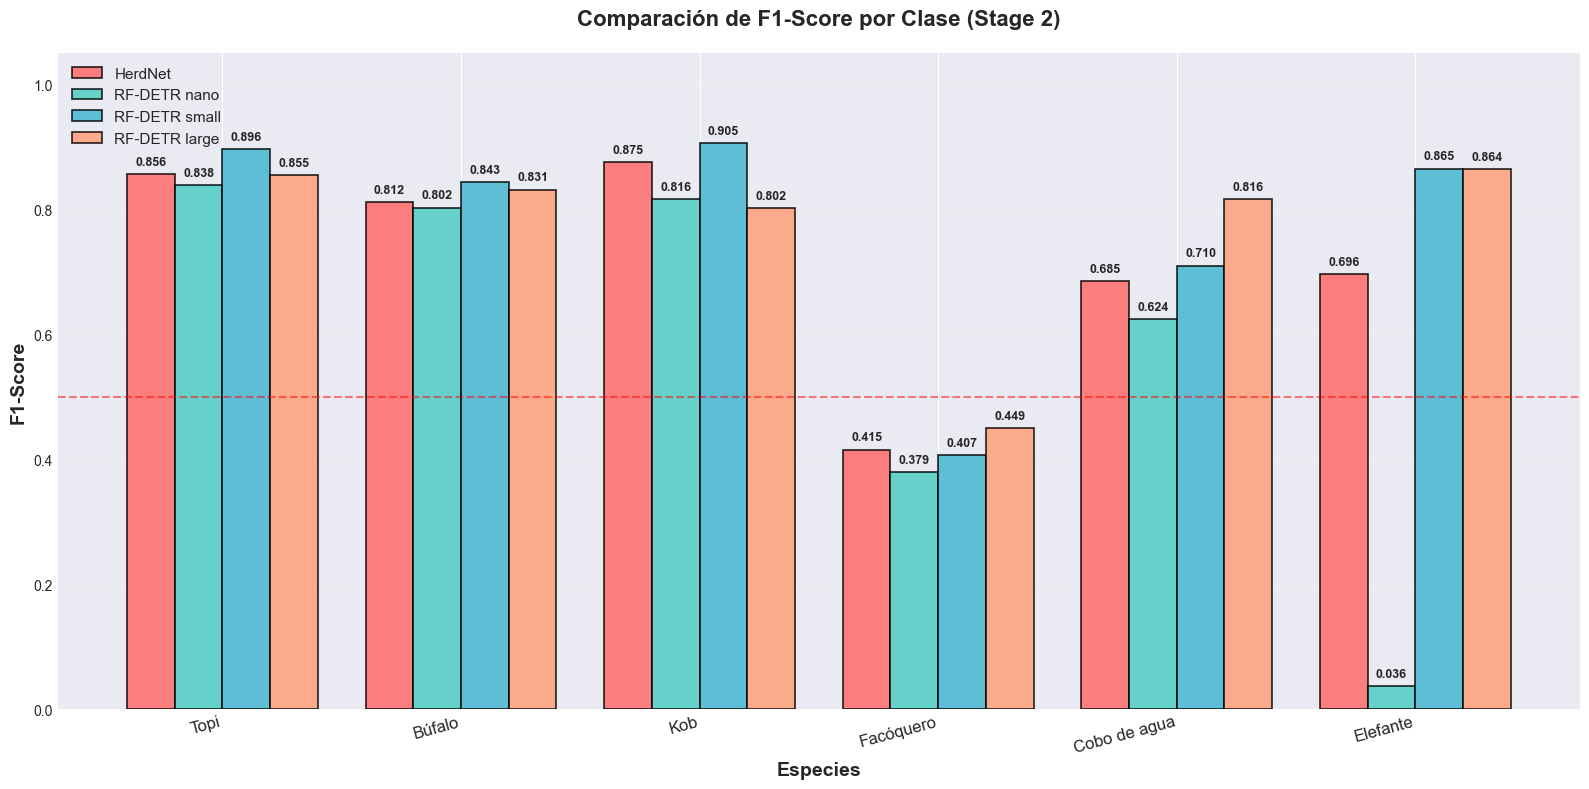


 Análisis de especies minoritarias (Stage 2):
------------------------------------------------------------

Facóquero:
  HerdNet             : F1=0.415, P=0.388, R=0.446
  RF-DETR nano        : F1=0.379, P=0.431, R=0.338
  RF-DETR small       : F1=0.407, P=0.510, R=0.338
  RF-DETR large       : F1=0.449, P=0.484, R=0.419

Cobo de agua:
  HerdNet             : F1=0.685, P=0.676, R=0.694
  RF-DETR nano        : F1=0.624, P=0.509, R=0.806
  RF-DETR small       : F1=0.710, P=0.846, R=0.611
  RF-DETR large       : F1=0.816, P=0.775, R=0.861


In [43]:
stage2_results = {k: v for k, v in results.items() if 'Fase 2' in k}

f1_data = {}

for model_name, metrics in stage2_results.items():
    simple_name = model_name.replace(' Fase 2', '')
    f1_data[simple_name] = [
        metrics['per_class'][class_name]['f1_score'] 
        for class_name in CLASS_MAP.values()
    ]

f1_df = pd.DataFrame(f1_data, index=list(CLASS_MAP.values()))

fig, ax = plt.subplots(figsize=(16, 8))

x = np.arange(len(CLASS_MAP))
n_models = len(f1_df.columns)
width = 0.8 / n_models

color_palette = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', 
                 '#C44569', '#F8B500', '#6A89CC', '#B8E994']
colors = color_palette[:n_models]

for idx, (model_name, f1_scores) in enumerate(f1_df.items()):
    offset = width * idx
    bars = ax.bar(x + offset, f1_scores, width, label=model_name, 
                  color=colors[idx], alpha=0.85, edgecolor='black', linewidth=1.2)

    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Especies', fontsize=14, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=14, fontweight='bold')
ax.set_title('Comparación de F1-Score por Clase (Stage 2)',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x + width * (n_models - 1) / 2)
ax.set_xticklabels(CLASS_MAP.values(), fontsize=12, rotation=15, ha='right')
ax.legend(loc='upper left', fontsize=11, framealpha=0.95)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, 1.05)

# Línea de referencia en 0.5
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, linewidth=1.5)

plt.tight_layout()

plt.savefig('f1_score_por_clase_stage2.png', dpi=DPI, bbox_inches='tight')
plt.show()

print("\n Análisis de especies minoritarias (Stage 2):")
print("-" * 60)
minoritarias = ["Facóquero", "Cobo de agua"]
for especie in minoritarias:
    print(f"\n{especie}:")
    for model_name in stage2_results.keys():
        simple_name = model_name.replace(' Fase 2', '')
        f1 = stage2_results[model_name]['per_class'][especie]['f1_score']
        prec = stage2_results[model_name]['per_class'][especie]['precision']
        rec = stage2_results[model_name]['per_class'][especie]['recall']
        print(f"  {simple_name:20s}: F1={f1:.3f}, P={prec:.3f}, R={rec:.3f}")

## 7. Matrices de Confusión (Stage 2)

In [44]:
from scipy.spatial.distance import cdist

def compute_confusion_matrix(
    gt_df: pd.DataFrame, 
    pred_df: pd.DataFrame, 
    class_map: Dict[int, str],
    radius: float
) -> np.ndarray:
    """Calcula la matriz de confusión entre predicciones y ground truth."""
    num_classes = len(class_map)
    confusion = np.zeros((num_classes, num_classes))
    
    all_images = sorted(set(gt_df["images"]) | set(pred_df["images"]))
    
    for image_name in all_images:
        gt_rows = gt_df[gt_df["images"] == image_name]
        pred_rows = pred_df[pred_df["images"] == image_name]
        
        if len(gt_rows) == 0 or len(pred_rows) == 0:
            continue
        
        gt_coords = np.array([(row['x'], row['y']) for _, row in gt_rows.iterrows()])
        gt_labels = np.array([row['labels'] for _, row in gt_rows.iterrows()])
        
        pred_coords = np.array([(row['x'], row['y']) for _, row in pred_rows.iterrows()])
        pred_labels = np.array([row['labels'] for _, row in pred_rows.iterrows()])
        
        distances = cdist(gt_coords, pred_coords, metric='euclidean')
        
        for i, (gt_label, gt_distances) in enumerate(zip(gt_labels, distances)):
            if len(gt_distances) == 0:
                continue
            
            min_dist_idx = np.argmin(gt_distances)
            min_dist = gt_distances[min_dist_idx]
            
            if min_dist <= radius:
                pred_label = pred_labels[min_dist_idx]
                confusion[gt_label - 1, pred_label - 1] += 1
    
    # Normalizar
    row_sums = confusion.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    confusion_normalized = confusion / row_sums
    
    return confusion_normalized


def plot_confusion_matrix(confusion_matrix: np.ndarray, class_names: List[str], model_name: str):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    im = ax.imshow(confusion_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
    
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha='right', fontsize=11)
    ax.set_yticklabels(class_names, fontsize=11)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            value = confusion_matrix[i, j]
            text_color = 'white' if value > 0.5 else 'black'
            ax.text(j, i, f'{value:.2f}',
                   ha="center", va="center", 
                   color=text_color, fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Clase Predicha', fontsize=13, fontweight='bold')
    ax.set_ylabel('Clase Real (Ground Truth)', fontsize=13, fontweight='bold')
    ax.set_title(f'Matriz de Confusión Normalizada - {model_name}', 
                fontsize=14, fontweight='bold', pad=15)
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Proporción', rotation=270, labelpad=20, fontsize=12)
    
    plt.tight_layout()
    return fig

In [50]:
class_names = list(CLASS_MAP.values())
confusion_matrices = {}

for model_name, pred_df in predictions_dfs.items():
    if 'Fase 2' not in model_name:
        continue
    
    simple_name = model_name.replace(' Fase 2', '')
    
    cm = compute_confusion_matrix(
        gt_df=gt_df,
        pred_df=pred_df,
        class_map=CLASS_MAP,
        radius=RADIO_DETECCION
    )
    
    confusion_matrices[simple_name] = cm

    fig = plot_confusion_matrix(cm, class_names, simple_name)
    plt.savefig(f'confusion_matrix_{simple_name.replace(" ", "_").lower()}_stage2.png', 
                dpi=DPI, bbox_inches='tight')
    plt.close(fig)

## 8. Análisis Cualitativo: Visualización de Detecciones (Stage 2)

Comparación visual entre modelos en escenarios de alta oclusión.

In [46]:
def create_comparison_panel(
    image_name: str,
    image_dir: Path,
    gt_df: pd.DataFrame,
    predictions_dfs: Dict[str, pd.DataFrame],
    class_map: Dict[int, str],
    class_colors: Dict[str, str],
    zoom_box: Optional[Tuple[int, int, int, int]] = None
):
    image_path = image_dir / image_name

    stage2_preds = {k.replace(' Fase 2', ''): v for k, v in predictions_dfs.items() 
                    if 'Fase 2' in k}
    
    gt_dets = gt_df[gt_df['images'] == image_name]
    
    n_models = len(stage2_preds) + 1
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 8))
    
    if n_models == 1:
        axes = [axes]
    
    img = Image.open(image_path)
    
    # Panel 1: Ground Truth
    ax = axes[0]
    ax.imshow(img)
    
    for _, det in gt_dets.iterrows():
        x, y = det['x'], det['y']
        label_id = int(det['labels'])
        class_name = class_map.get(label_id, "Unknown")
        color = class_colors.get(class_name, "white")
        
        circle = Circle((x, y), radius=12, color=color, fill=True, 
                       alpha=0.6, linewidth=2)
        ax.add_patch(circle)
    
    if zoom_box:
        x_min, y_min, x_max, y_max = zoom_box
        rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                        linewidth=3, edgecolor='red', facecolor='none', 
                        linestyle='--')
        ax.add_patch(rect)
    
    ax.set_title('Ground Truth', fontsize=14, fontweight='bold', pad=10)
    ax.axis('off')
    
    # Paneles para cada modelo
    for idx, (model_name, pred_df) in enumerate(stage2_preds.items(), start=1):
        ax = axes[idx]
        ax.imshow(img)
        
        model_dets = pred_df[pred_df['images'] == image_name]
        
        for _, det in model_dets.iterrows():
            x, y = det['x'], det['y']
            label_id = int(det['labels'])
            class_name = class_map.get(label_id, "Unknown")
            color = class_colors.get(class_name, "white")
            
            circle = Circle((x, y), radius=12, color=color, fill=False, 
                          linewidth=2.5, alpha=0.9)
            ax.add_patch(circle)
        
        if zoom_box:
            x_min, y_min, x_max, y_max = zoom_box
            rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                            linewidth=3, edgecolor='red', facecolor='none', 
                            linestyle='--')
            ax.add_patch(rect)
        
        n_dets = len(model_dets)
        n_gt = len(gt_dets)
        
        ax.set_title(f'{model_name}\n({n_dets} dets vs {n_gt} GT)', 
                    fontsize=12, fontweight='bold', pad=10)
        ax.axis('off')
    
    plt.tight_layout()
    return fig


def find_best_crop_regions(
    gt_df: pd.DataFrame,
    predictions_dfs: Dict[str, pd.DataFrame],
    image_name: str,
    img_width: int,
    img_height: int,
    crop_size: int = 500,
    max_crops: int = 3
) -> List[Tuple[int, int, int, int]]:
    """
    Encuentra las mejores regiones para hacer crops basándose en densidad de detecciones.
    
    Returns:
        Lista de tuplas (x_min, y_min, x_max, y_max) para cada crop
    """
    # Obtener todas las detecciones (GT + predicciones)
    all_points = []
    
    # Ground truth
    gt_dets = gt_df[gt_df['images'] == image_name]
    for _, det in gt_dets.iterrows():
        all_points.append((det['x'], det['y']))
    
    # Predicciones (solo Stage 2)
    for model_name, pred_df in predictions_dfs.items():
        if 'Fase 2' in model_name:
            model_dets = pred_df[pred_df['images'] == image_name]
            for _, det in model_dets.iterrows():
                all_points.append((det['x'], det['y']))
    
    if len(all_points) == 0:
        return []
    
    # Convertir a array numpy
    points = np.array(all_points)
    
    # Usar DBSCAN para encontrar clusters
    from sklearn.cluster import DBSCAN
    
    if len(points) < 3:
        centers = points
    else:
        # DBSCAN para encontrar regiones densas
        clustering = DBSCAN(eps=crop_size/2, min_samples=2).fit(points)
        labels = clustering.labels_
        
        # Obtener centros de cada cluster
        centers = []
        for label in set(labels):
            if label == -1:  # Ruido
                continue
            cluster_points = points[labels == label]
            center = cluster_points.mean(axis=0)
            centers.append(center)
        
        # Si no hay suficientes clusters, usar puntos con más vecinos
        if len(centers) < max_crops:
            densities = []
            for point in points:
                dist = np.sqrt(((points - point)**2).sum(axis=1))
                density = (dist < crop_size/2).sum()
                densities.append(density)
            
            dense_indices = np.argsort(densities)[::-1][:max_crops]
            centers = points[dense_indices]
        else:
            centers = np.array(centers)
    
    # Crear bounding boxes
    crops = []
    half_size = crop_size // 2
    
    for center in centers[:max_crops]:
        cx, cy = int(center[0]), int(center[1])
        
        x_min = max(0, cx - half_size)
        y_min = max(0, cy - half_size)
        x_max = min(img_width, cx + half_size)
        y_max = min(img_height, cy + half_size)
        
        # Ajustar para mantener tamaño
        if x_max - x_min < crop_size:
            if x_min == 0:
                x_max = min(img_width, crop_size)
            else:
                x_min = max(0, img_width - crop_size)
        
        if y_max - y_min < crop_size:
            if y_min == 0:
                y_max = min(img_height, crop_size)
            else:
                y_min = max(0, img_height - crop_size)
        
        crops.append((x_min, y_min, x_max, y_max))
    
    return crops


def create_crop_comparison(
    image_name: str,
    image_dir: Path,
    gt_df: pd.DataFrame,
    predictions_dfs: Dict[str, pd.DataFrame],
    class_map: Dict[int, str],
    class_colors: Dict[str, str],
    crop_box: Tuple[int, int, int, int],
    crop_idx: int
):
    """Crea un panel de comparación para un crop específico."""
    image_path = image_dir / image_name
    
    if not image_path.exists():
        return None
    
    x_min, y_min, x_max, y_max = crop_box
    
    stage2_preds = {k.replace(' Fase 2', ''): v for k, v in predictions_dfs.items() 
                    if 'Fase 2' in k}
    
    gt_dets = gt_df[gt_df['images'] == image_name]
    
    n_models = len(stage2_preds) + 1
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 6))
    
    if n_models == 1:
        axes = [axes]
    
    img = Image.open(image_path)
    img_crop = img.crop((x_min, y_min, x_max, y_max))
    
    # Panel 1: Ground Truth
    ax = axes[0]
    ax.imshow(img_crop)
    
    for _, det in gt_dets.iterrows():
        x, y = det['x'], det['y']
        
        if x_min <= x <= x_max and y_min <= y <= y_max:
            x_crop = x - x_min
            y_crop = y - y_min
            
            label_id = int(det['labels'])
            class_name = class_map.get(label_id, "Unknown")
            color = class_colors.get(class_name, "white")
            
            circle = Circle((x_crop, y_crop), radius=8, color=color, fill=True, 
                           alpha=0.7, linewidth=2)
            ax.add_patch(circle)
            
            ax.text(x_crop, y_crop - 12, class_name[:3], 
                   color=color, fontsize=8, fontweight='bold',
                   ha='center', bbox=dict(boxstyle='round,pad=0.3', 
                                         facecolor='black', alpha=0.5))
    
    ax.set_title('Ground Truth', fontsize=12, fontweight='bold', pad=8)
    ax.axis('off')
    
    # Paneles para cada modelo
    for idx, (model_name, pred_df) in enumerate(stage2_preds.items(), start=1):
        ax = axes[idx]
        ax.imshow(img_crop)
        
        model_dets = pred_df[pred_df['images'] == image_name]
        dets_in_crop = 0
        
        for _, det in model_dets.iterrows():
            x, y = det['x'], det['y']
            
            if x_min <= x <= x_max and y_min <= y <= y_max:
                dets_in_crop += 1
                x_crop = x - x_min
                y_crop = y - y_min
                
                label_id = int(det['labels'])
                class_name = class_map.get(label_id, "Unknown")
                color = class_colors.get(class_name, "white")
                
                circle = Circle((x_crop, y_crop), radius=8, color=color, fill=False, 
                              linewidth=2.5, alpha=0.9)
                ax.add_patch(circle)
                
                ax.text(x_crop, y_crop - 12, class_name[:3], 
                       color=color, fontsize=8, fontweight='bold',
                       ha='center', bbox=dict(boxstyle='round,pad=0.3', 
                                             facecolor='black', alpha=0.5))
        
        gt_in_crop = sum(1 for _, det in gt_dets.iterrows() 
                        if x_min <= det['x'] <= x_max and y_min <= det['y'] <= y_max)
        
        ax.set_title(f'{model_name}\n({dets_in_crop} dets vs {gt_in_crop} GT)', 
                    fontsize=11, fontweight='bold', pad=8)
        ax.axis('off')
    
    fig.suptitle(f'Crop {crop_idx} - Región: [{x_min}:{x_max}, {y_min}:{y_max}]', 
                fontsize=13, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    return fig

Generando paneles de comparación cualitativa (Stage 2)...

Buscando imágenes en: data-delplanque/test
Tamaño de crops: 500x500 px

Procesando: S_07_05_16_DSC00640.JPG

Generando panel de imagen completa...
Guardado: comparison_panel_s_07_05_16_dsc00640_full_stage2.png


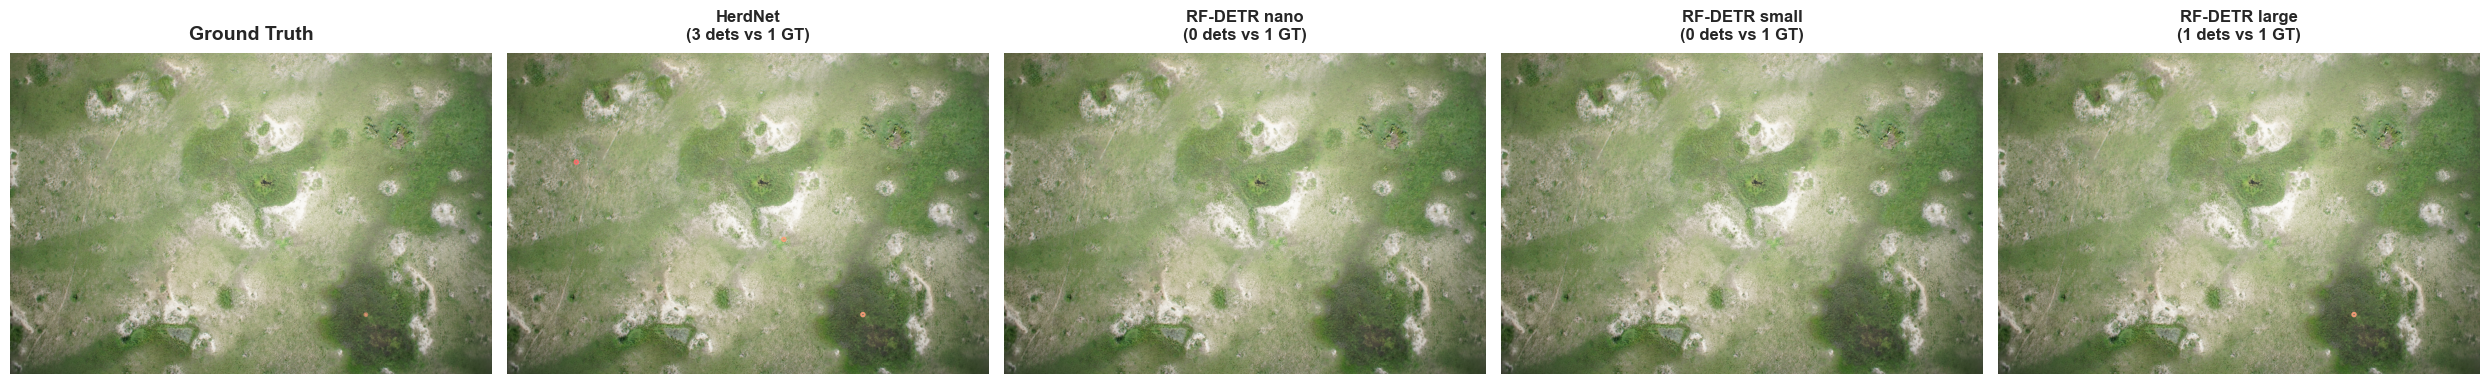


Buscando regiones densas para crops de 500x500 px...
   Encontradas 3 regiones de interés

Generando crop 1/3...
   Guardado: comparison_panel_s_07_05_16_dsc00640_crop1_stage2.png


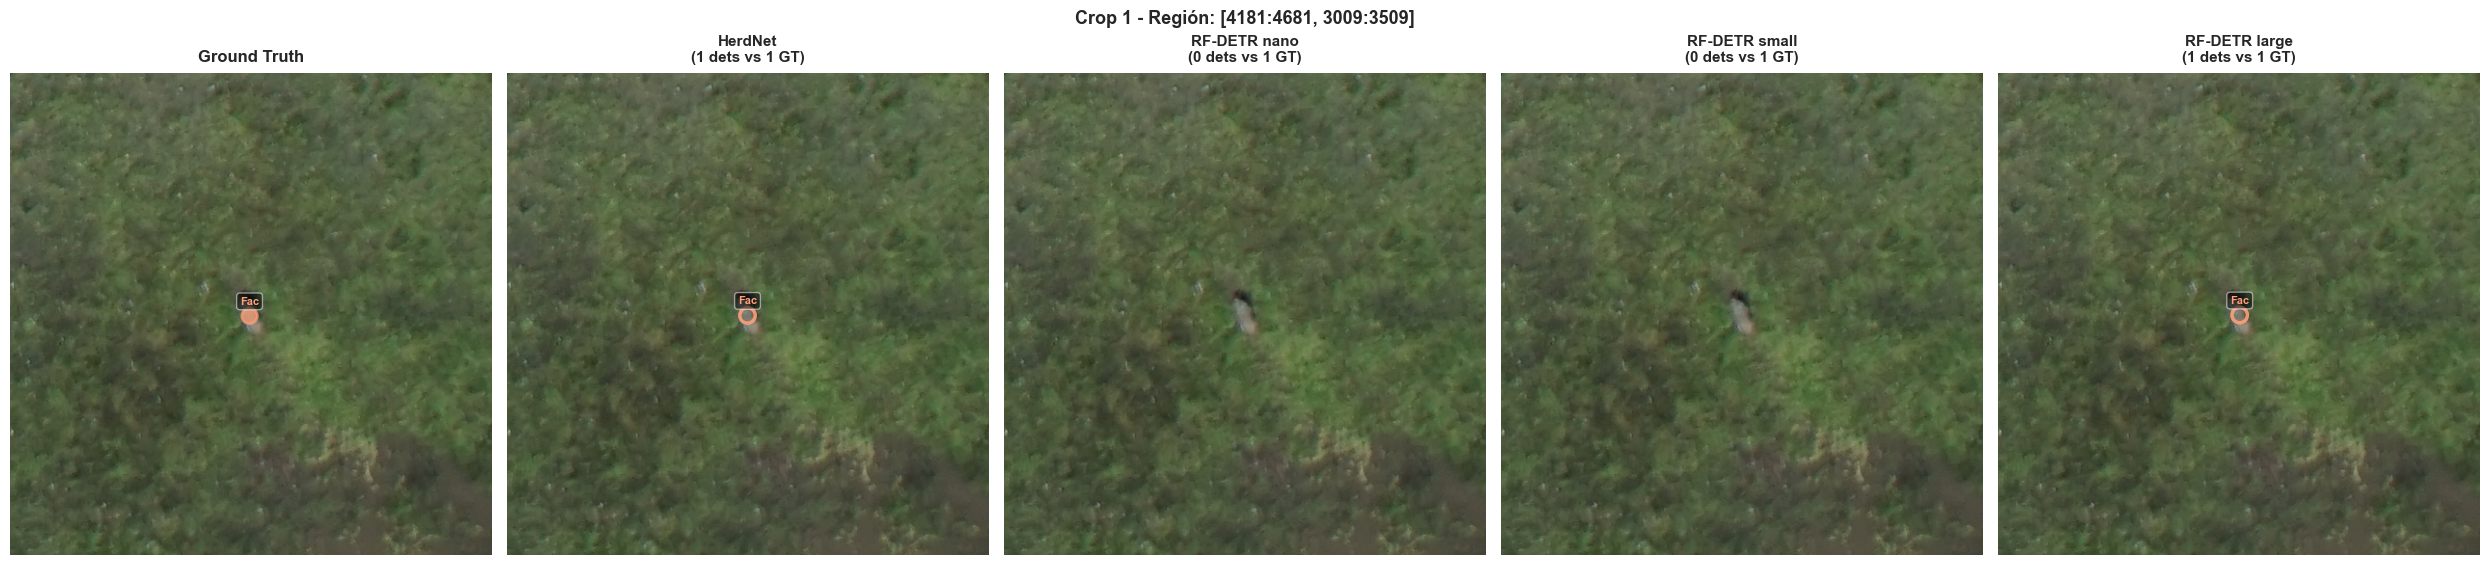


Generando crop 2/3...
   Guardado: comparison_panel_s_07_05_16_dsc00640_crop2_stage2.png


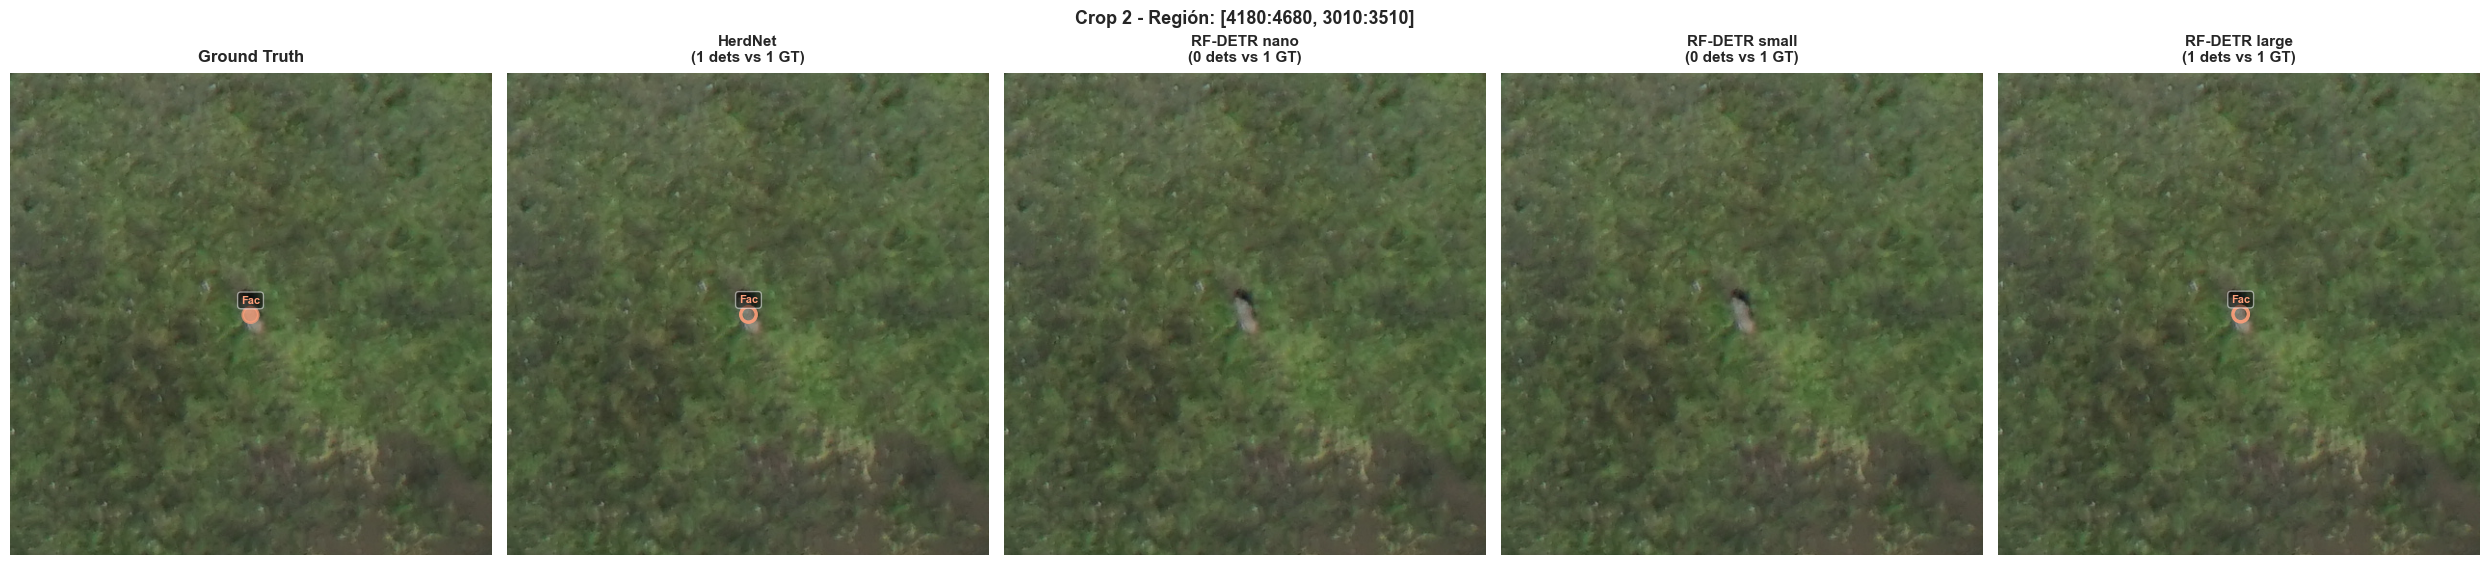


Generando crop 3/3...
   Guardado: comparison_panel_s_07_05_16_dsc00640_crop3_stage2.png


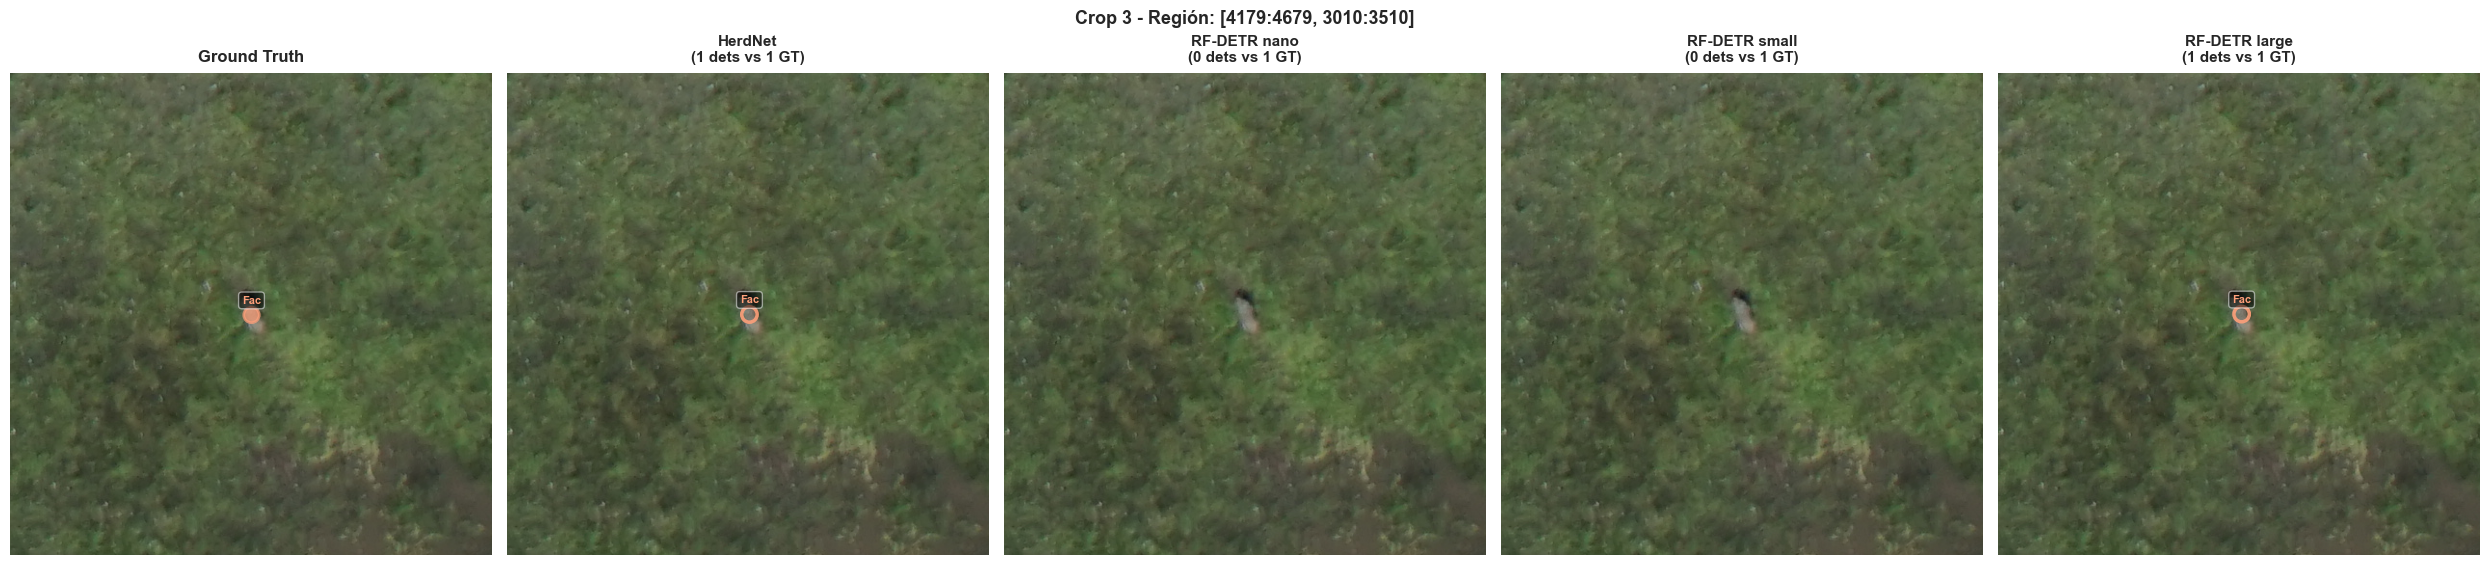


Procesando: 112351277475e7c55f29d5a3c8c5a349216b514a.JPG

Generando panel de imagen completa...
Guardado: comparison_panel_112351277475e7c55f29d5a3c8c5a349216b514a_full_stage2.png


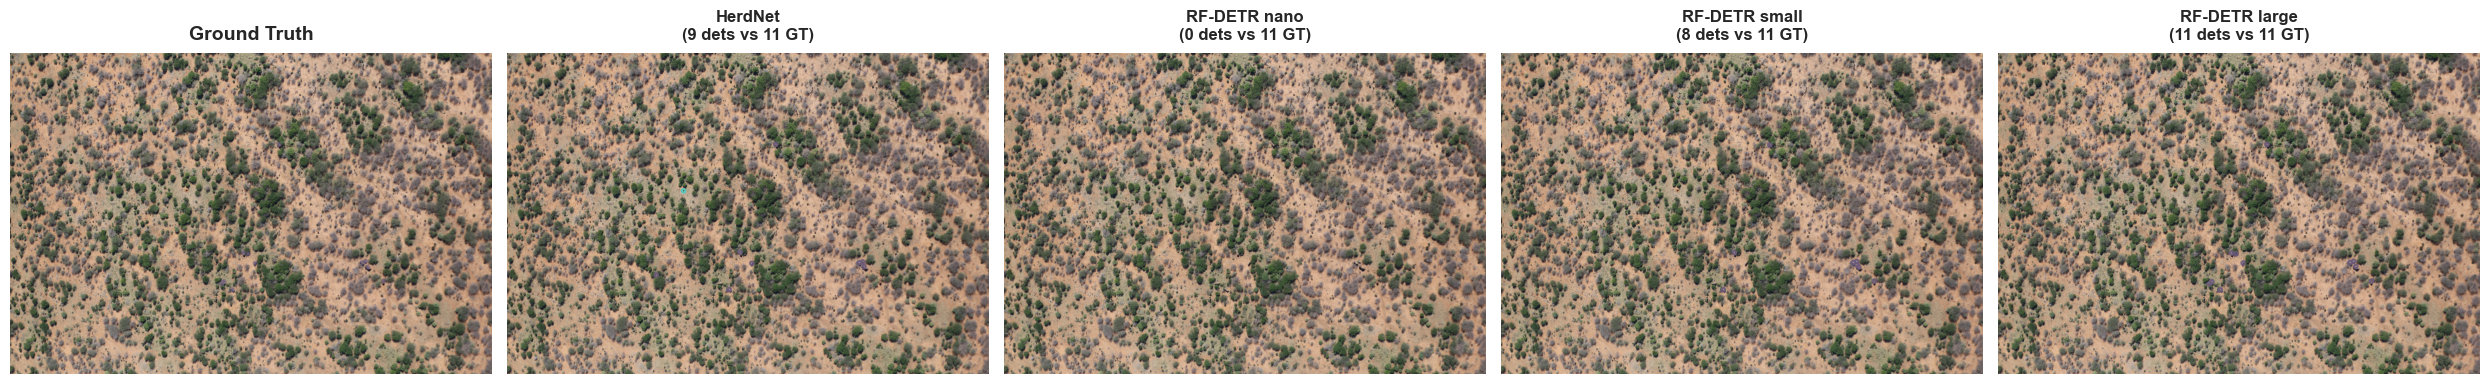


Buscando regiones densas para crops de 500x500 px...
   Encontradas 3 regiones de interés

Generando crop 1/3...
   Guardado: comparison_panel_112351277475e7c55f29d5a3c8c5a349216b514a_crop1_stage2.png


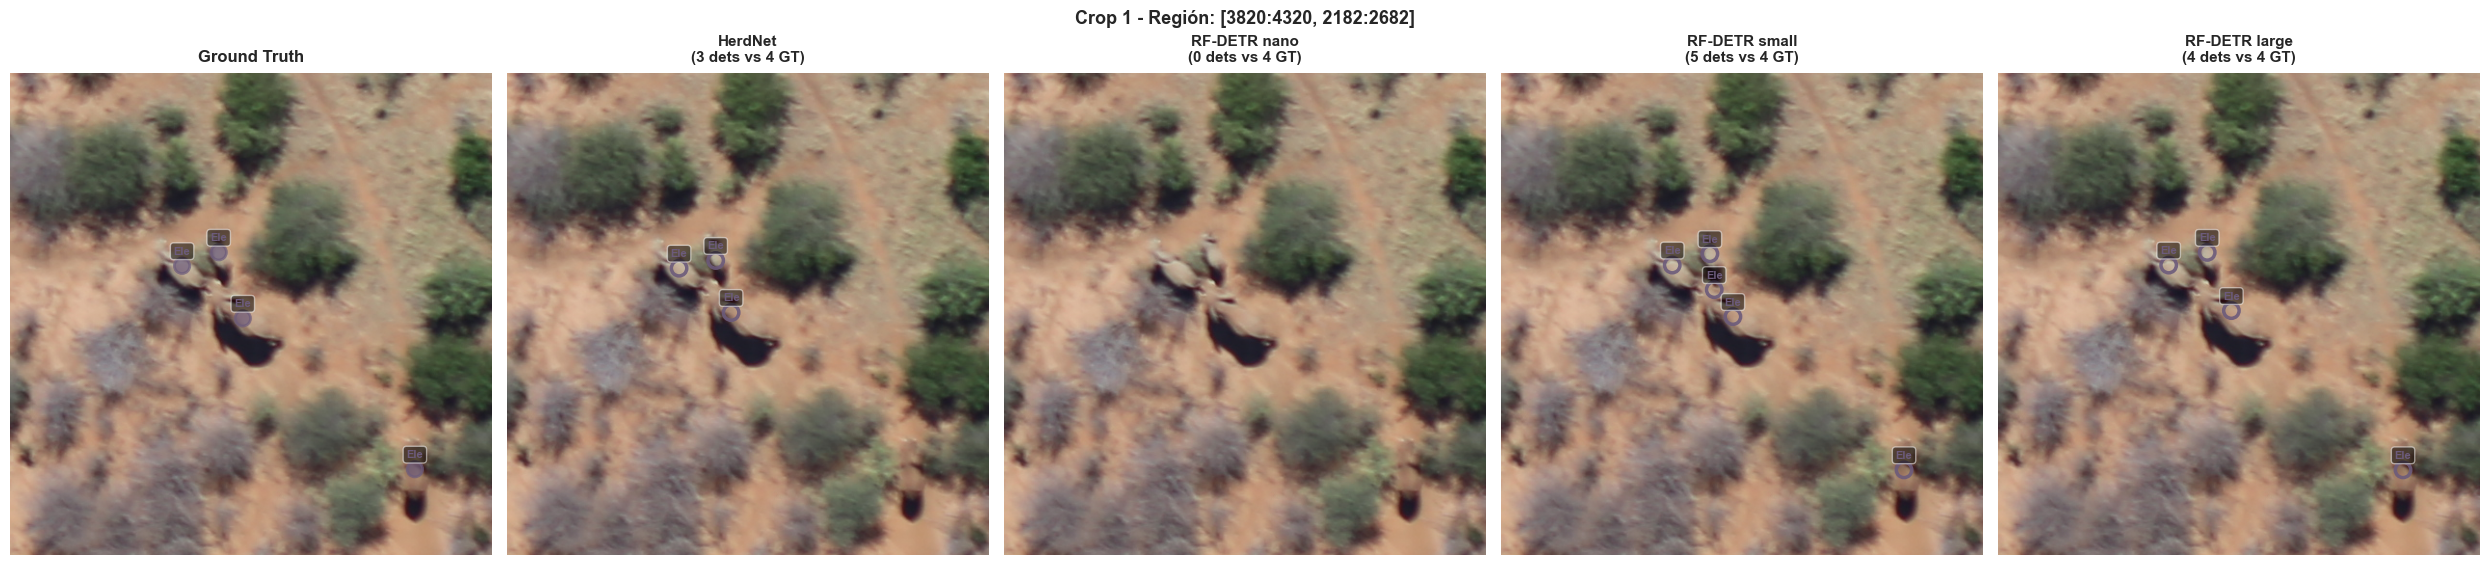


Generando crop 2/3...
   Guardado: comparison_panel_112351277475e7c55f29d5a3c8c5a349216b514a_crop2_stage2.png


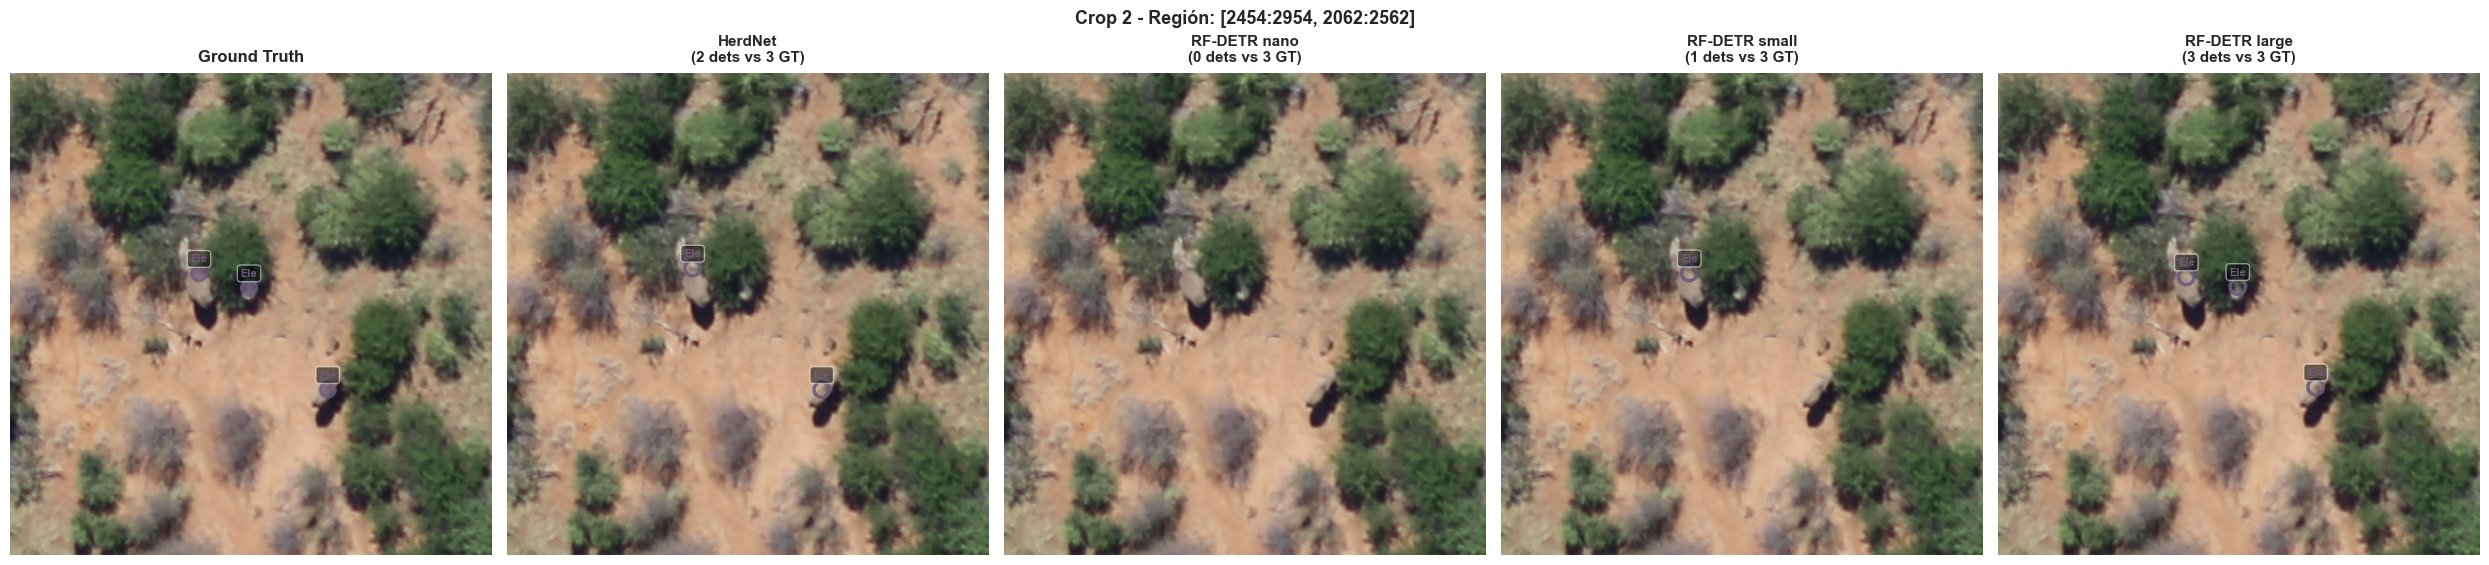


Generando crop 3/3...
   Guardado: comparison_panel_112351277475e7c55f29d5a3c8c5a349216b514a_crop3_stage2.png


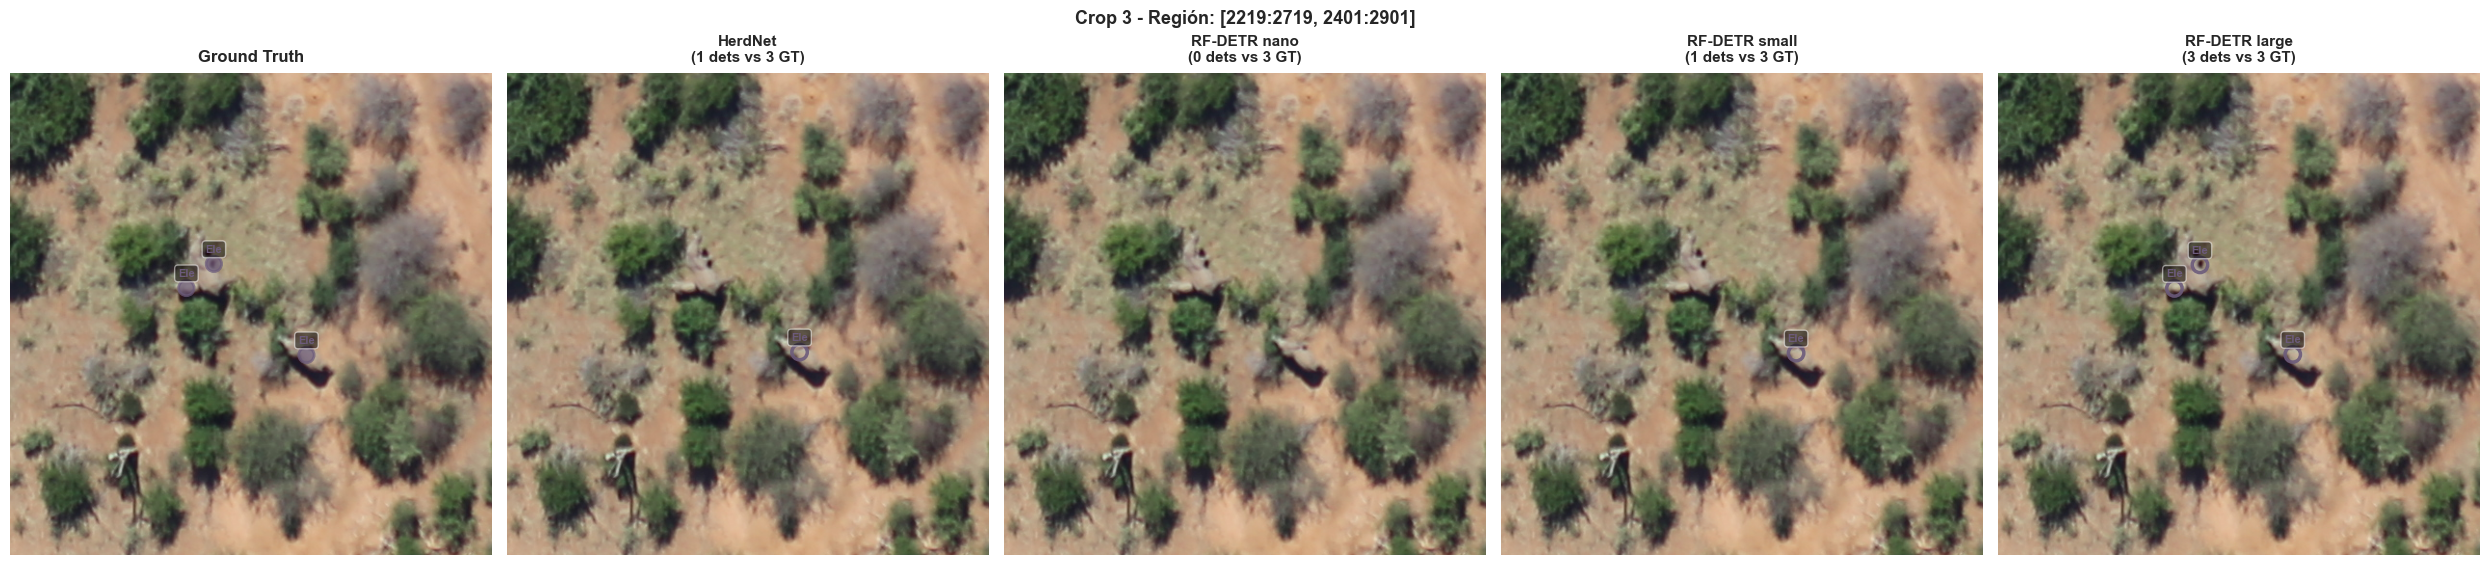


Proceso completado: 2/2 imágenes


In [47]:
IMAGES_DIR = DATA_ROOT / "test"
CROP_SIZE = 500  # Tamaño de los crops en píxeles
MAX_CROPS_PER_IMAGE = 3  # Máximo de crops por imagen

# Seleccionar imágenes de ejemplo
example_images = [
    "S_07_05_16_DSC00640.JPG",  # Facóquero
    "112351277475e7c55f29d5a3c8c5a349216b514a.JPG",  # Elefante
]

print("Generando paneles de comparación cualitativa (Stage 2)...\n")
print(f"Buscando imágenes en: {IMAGES_DIR}")
print(f"Tamaño de crops: {CROP_SIZE}x{CROP_SIZE} px\n")

if not IMAGES_DIR.exists():
    print(f"ERROR: El directorio de imágenes no existe: {IMAGES_DIR}")
    print("   Por favor, verifica la ruta en DATA_ROOT\n")
else:
    processed_count = 0
    
    for img_name in example_images:
        img_path = IMAGES_DIR / img_name
        
        if not img_path.exists():
            print(f"Imagen no encontrada: {img_name}")
            print(f"   Ruta buscada: {img_path}")
            print(f"   Saltando...\n")
            continue
        
        print("=" * 80)
        print(f"Procesando: {img_name}")
        print("=" * 80)
        
        # Verificar detecciones
        has_gt = len(gt_df[gt_df['images'] == img_name]) > 0
        
        has_preds = False
        for model_name, pred_df in predictions_dfs.items():
            if 'Fase 2' in model_name:
                if len(pred_df[pred_df['images'] == img_name]) > 0:
                    has_preds = True
                    break
        
        if not has_gt:
            print(f"No hay ground truth para esta imagen")
        if not has_preds:
            print(f"No hay predicciones (Stage 2) para esta imagen")
        
        try:
            # 1. Generar panel de imagen completa
            print("\nGenerando panel de imagen completa...")
            
            fig = create_comparison_panel(
                image_name=img_name,
                image_dir=IMAGES_DIR,
                gt_df=gt_df,
                predictions_dfs=predictions_dfs,
                class_map=CLASS_MAP,
                class_colors=CLASS_COLORS,
                zoom_box=None
            )
            
            if fig:
                clean_name = img_name.replace('.JPG', '').replace('.jpg', '').lower()
                clean_name = clean_name.replace('.', '_')
                
                output_filename = f'comparison_panel_{clean_name}_full_stage2.png'
                plt.savefig(output_filename, dpi=DPI, bbox_inches='tight')
                print(f"Guardado: {output_filename}")
                plt.show()
                
                processed_count += 1
            
            # 2. Encontrar mejores regiones para crops
            print(f"\nBuscando regiones densas para crops de {CROP_SIZE}x{CROP_SIZE} px...")
            
            img = Image.open(img_path)
            img_width, img_height = img.size
            
            crop_regions = find_best_crop_regions(
                gt_df=gt_df,
                predictions_dfs=predictions_dfs,
                image_name=img_name,
                img_width=img_width,
                img_height=img_height,
                crop_size=CROP_SIZE,
                max_crops=MAX_CROPS_PER_IMAGE
            )
            
            print(f"   Encontradas {len(crop_regions)} regiones de interés")
            
            # 3. Generar crops
            for crop_idx, crop_box in enumerate(crop_regions, 1):
                print(f"\nGenerando crop {crop_idx}/{len(crop_regions)}...")
                
                fig_crop = create_crop_comparison(
                    image_name=img_name,
                    image_dir=IMAGES_DIR,
                    gt_df=gt_df,
                    predictions_dfs=predictions_dfs,
                    class_map=CLASS_MAP,
                    class_colors=CLASS_COLORS,
                    crop_box=crop_box,
                    crop_idx=crop_idx
                )
                
                if fig_crop:
                    crop_filename = f'comparison_panel_{clean_name}_crop{crop_idx}_stage2.png'
                    plt.savefig(crop_filename, dpi=DPI, bbox_inches='tight')
                    print(f"   Guardado: {crop_filename}")
                    plt.show()
        
        except Exception as e:
            print(f"\n Error procesando {img_name}: {str(e)}")
            import traceback
            traceback.print_exc()
        
        print()  # Línea en blanco
    
    print("=" * 80)
    print(f"Proceso completado: {processed_count}/{len(example_images)} imágenes")
    print("=" * 80)